In [1]:
import eagleSqlTools as sql
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import os
import pickle

EAGLE

In [2]:
import eagleSqlTools as sql
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

username = 'rvj764'
password = 'sv34QMT7'

con = sql.connect(username, password=password)

query = """SELECT
                s.MassType_Star as stellar_mass,
                s.StarFormationRate as SFR,
                m.g_nodust as g_nodust,
                m.r_nodust as r_nodust,
                dust.SDSS_g as g_dust,
                dust.SDSS_r as r_dust
            FROM
                RefL0100N1504_SubHalo as s
            LEFT JOIN
                RefL0100N1504_Magnitudes as m ON s.GalaxyID = m.GalaxyID
            LEFT JOIN
                RefL0100N1504_DustyMagnitudes as dust ON s.GalaxyID = dust.GalaxyID
            WHERE
                s.SnapNum = 28
                AND s.MassType_Star > 1e8"""

data = sql.execute_query(con, query)
np.save('EAGLE_data.npy' , data)
load_data = np.load('EAGLE_data.npy')

Number of galaxies(EAGLE): 40312


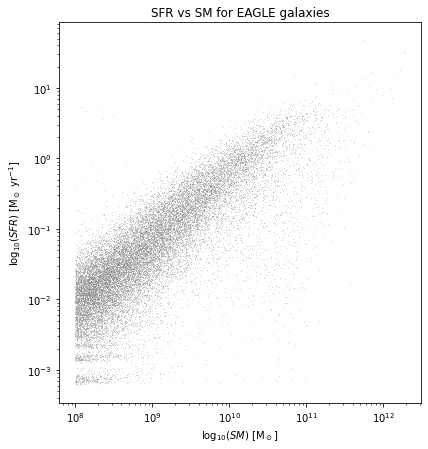

In [3]:
#1. Get all redshift z=0 galaxies from eagle

num_galaxies = len(load_data)
print("Number of galaxies(EAGLE):",num_galaxies)

#2.Make SFR vs SM plot

# Extract stellar mass and star formation rate from the loaded data
stellar_mass = load_data['stellar_mass']
SFR = load_data['SFR']

# Create a log scatter plot of SFR vs SM
plt.figure(figsize=(6.5,7))
plt.scatter(stellar_mass, SFR, s=1, alpha=0.4, c='gray', linewidth=0)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\log_{10}(SM)\ [\mathrm{M}_\odot]$') # SM
plt.ylabel(r'$\log_{10}(SFR)\ [\mathrm{M}_\odot\ \mathrm{yr}^{-1}]$') #SFR
plt.title('SFR vs SM for EAGLE galaxies')
plt.show()

Number of MWAs(EAGLE): 302


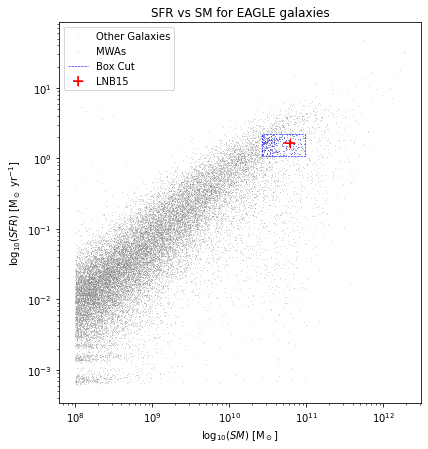

In [4]:
# 3. Make a box cut on the greater galaxy sample to pick out MWAs.

load_data = np.load('EAGLE_data.npy')

# Define the Milky Way analog (MWA) selection criteria
mw_stellar_mass = 6.08e10
mw_stellar_mass_err = 1.14e10
mw_sfr = 1.65
mw_sfr_err = 0.19

# Apply the box cut to select MWAs
mwa_indices = np.where(
    (load_data['stellar_mass'] >= mw_stellar_mass - 3 * mw_stellar_mass_err) &
    (load_data['stellar_mass'] <= mw_stellar_mass + 3 * mw_stellar_mass_err) &
    (load_data['SFR'] >= mw_sfr - 3 * mw_sfr_err) &
    (load_data['SFR'] <= mw_sfr + 3 * mw_sfr_err))

# Extract stellar mass and star formation rate for MWAs and non-MWAs
stellar_mass = load_data['stellar_mass']
SFR = load_data['SFR']
mwa_stellar_mass = stellar_mass[mwa_indices]
mwa_SFR = SFR[mwa_indices]

print("Number of MWAs(EAGLE):", len(mwa_stellar_mass))

#4. Overplot your MWAs on your SFR vs SM plot in a different colour.

plt.figure(figsize=(6.5,7))
plt.scatter(stellar_mass, SFR, s=1, alpha=0.4, c='gray', linewidth=0, label='Other Galaxies')
plt.scatter(mwa_stellar_mass, mwa_SFR,s=1, alpha=0.4, c='blue', linewidth=0, label='MWAs')

plt.errorbar(mw_stellar_mass, mw_sfr, xerr=mw_stellar_mass_err, yerr=mw_sfr_err, color='red', fmt='+', markersize=10, label='LNB15')

rectangle_x = [mw_stellar_mass - 3 * mw_stellar_mass_err, mw_stellar_mass + 3 * mw_stellar_mass_err, mw_stellar_mass + 3 * mw_stellar_mass_err, mw_stellar_mass - 3 * mw_stellar_mass_err, mw_stellar_mass - 3 * mw_stellar_mass_err]
rectangle_y = [mw_sfr - 3 * mw_sfr_err, mw_sfr - 3 * mw_sfr_err, mw_sfr + 3 * mw_sfr_err, mw_sfr + 3 * mw_sfr_err, mw_sfr - 3 * mw_sfr_err]
plt.plot(rectangle_x, rectangle_y, color='blue', linewidth=0.6, linestyle='--', label='Box Cut')

plt.xlabel(r'$\log_{10}(SM)\ [\mathrm{M}_\odot]$') # SM
plt.ylabel(r'$\log_{10}(SFR)\ [\mathrm{M}_\odot\ \mathrm{yr}^{-1}]$') #SFR
plt.title('SFR vs SM for EAGLE galaxies')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()


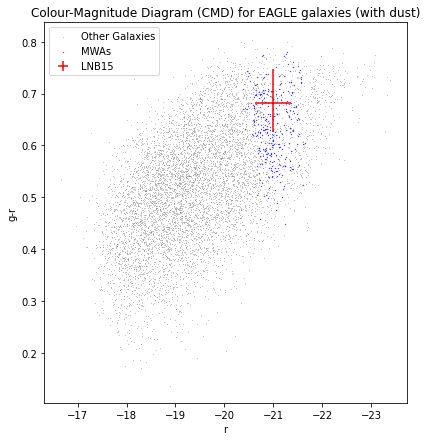

In [5]:
#5. Make a CMD (colour-magnitude diagram) with dust

load_data = np.load('EAGLE_data.npy')

# Compute the color for all galaxies and MWAs
g_r_all = load_data['g_dust'] - load_data['r_dust']
stellarphotometrics_r_all = load_data['r_dust']

# Define the Milky Way analog (MWA) selection criteria
mw_stellar_mass = 6.08e10
mw_stellar_mass_err = 1.14e10
mw_sfr = 1.65
mw_sfr_err = 0.19

# Apply the box cut to select MWAs
mwa_indices = np.where(
    (load_data['stellar_mass'] >= mw_stellar_mass - 3 * mw_stellar_mass_err) &
    (load_data['stellar_mass'] <= mw_stellar_mass + 3 * mw_stellar_mass_err) &
    (load_data['SFR'] >= mw_sfr - 3 * mw_sfr_err) &
    (load_data['SFR'] <= mw_sfr + 3 * mw_sfr_err))

# Extract colors and magnitudes for MWAs
g_r_mwa = g_r_all[mwa_indices]
r_mwa = stellarphotometrics_r_all[mwa_indices]

# LNB15 values
lnb15_r = -21.00  # Absolute magnitude Mr
lnb15_g_r = 0.682  # Color (g-r)
lnb15_r_err = [0.37, 0.38]  # Error in r
lnb15_g_r_err = [0.056, 0.066]  # Error in (g-r)

#for combined plot
dust_stellarphotometrics_r_all = stellarphotometrics_r_all
dust_g_r_all = g_r_all

# plot CMD
plt.figure(figsize=(6.5,7))
plt.scatter(stellarphotometrics_r_all, g_r_all, s=1, alpha=0.6, c='gray', linewidth=0, label='Other Galaxies')
plt.scatter(r_mwa, g_r_mwa, s=2, alpha=0.6, c='blue', linewidth=0, label='MWAs')

# Overplot the LNB15 values
lnb15_r_err_2d = np.array([[lnb15_r_err[0]], [lnb15_r_err[1]]])
lnb15_g_r_err_2d = np.array([[lnb15_g_r_err[0]], [lnb15_g_r_err[1]]])

plt.errorbar(lnb15_r, lnb15_g_r, xerr=lnb15_r_err_2d, yerr=lnb15_g_r_err_2d, fmt='+', c='red', markersize=2, label='LNB15')

plt.gca().invert_xaxis() 
plt.ylabel('g-r')  
plt.xlabel('r')
plt.title('Colour-Magnitude Diagram (CMD) for EAGLE galaxies (with dust)')
plt.legend()
plt.show()

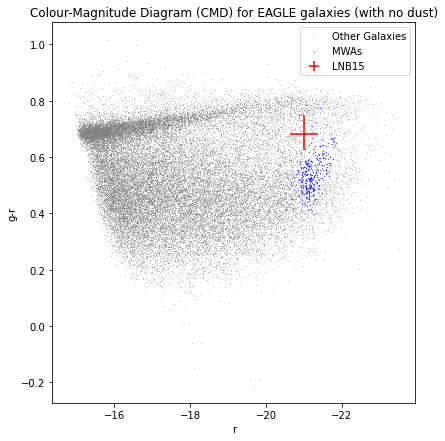

In [6]:
#5. Make a CMD (colour-magnitude diagram) no dust

load_data = np.load('EAGLE_data.npy')

# Compute the color for all galaxies and MWAs
g_r_all = load_data['g_nodust'] - load_data['r_nodust']
stellarphotometrics_r_all = load_data['r_nodust']

mw_stellar_mass = 6.08e10
mw_stellar_mass_err = 1.14e10
mw_sfr = 1.65
mw_sfr_err = 0.19

mwa_indices = np.where(
    (load_data['stellar_mass'] >= mw_stellar_mass - 3 * mw_stellar_mass_err) &
    (load_data['stellar_mass'] <= mw_stellar_mass + 3 * mw_stellar_mass_err) &
    (load_data['SFR'] >= mw_sfr - 3 * mw_sfr_err) &
    (load_data['SFR'] <= mw_sfr + 3 * mw_sfr_err))

g_r_mwa = g_r_all[mwa_indices]
r_mwa = stellarphotometrics_r_all[mwa_indices]

# LNB15 values
lnb15_r = -21.00  # Absolute magnitude Mr
lnb15_g_r = 0.682  # Color (g-r)
lnb15_r_err = [0.37, 0.38]  # Error in r
lnb15_g_r_err = [0.056, 0.066]  # Error in (g-r)

# Plot CMD
plt.figure(figsize=(6.5,7))
plt.scatter(stellarphotometrics_r_all, g_r_all, s=1, alpha=0.6, c='gray', linewidth=0, label='Other Galaxies')
plt.scatter(r_mwa, g_r_mwa, s=2, alpha=0.6, c='blue', linewidth=0, label='MWAs')

lnb15_r_err_2d = np.array([[lnb15_r_err[0]], [lnb15_r_err[1]]])
lnb15_g_r_err_2d = np.array([[lnb15_g_r_err[0]], [lnb15_g_r_err[1]]])

plt.errorbar(lnb15_r, lnb15_g_r, xerr=lnb15_r_err_2d, yerr=lnb15_g_r_err_2d, fmt='+', c='red', markersize=2, label='LNB15')

plt.gca().invert_xaxis() 
plt.ylabel('g-r')  
plt.xlabel('r')
plt.title('Colour-Magnitude Diagram (CMD) for EAGLE galaxies (with no dust)')
plt.legend()
plt.show()



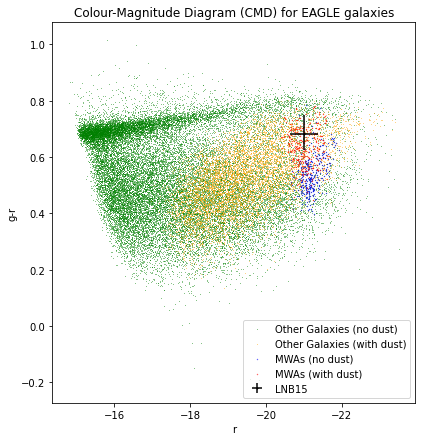

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
load_data = np.load('EAGLE_data.npy')

# Compute the color for all galaxies and MWAs (no dust)
g_r_all_nodust = load_data['g_nodust'] - load_data['r_nodust']
stellarphotometrics_r_all_nodust = load_data['r_nodust']

# Compute the color for all galaxies and MWAs (with dust)
g_r_all_dust = load_data['g_dust'] - load_data['r_dust']
stellarphotometrics_r_all_dust = load_data['r_dust']

# Define the Milky Way analog (MWA) selection criteria
mw_stellar_mass = 6.08e10
mw_stellar_mass_err = 1.14e10
mw_sfr = 1.65
mw_sfr_err = 0.19

# Apply the box cut to select MWAs
mwa_indices = np.where(
    (load_data['stellar_mass'] >= mw_stellar_mass - 3 * mw_stellar_mass_err) &
    (load_data['stellar_mass'] <= mw_stellar_mass + 3 * mw_stellar_mass_err) &
    (load_data['SFR'] >= mw_sfr - 3 * mw_sfr_err) &
    (load_data['SFR'] <= mw_sfr + 3 * mw_sfr_err))

# Extract colors and magnitudes for MWAs (no dust)
g_r_mwa_nodust = g_r_all_nodust[mwa_indices]
r_mwa_nodust = stellarphotometrics_r_all_nodust[mwa_indices]

# Extract colors and magnitudes for MWAs (with dust)
g_r_mwa_dust = g_r_all_dust[mwa_indices]
r_mwa_dust = stellarphotometrics_r_all_dust[mwa_indices]

# LNB15 values
lnb15_r = -21.00  # Absolute magnitude Mr
lnb15_g_r = 0.682  # Color (g-r)
lnb15_r_err = [0.37, 0.38]  # Error in r
lnb15_g_r_err = [0.056, 0.066]  # Error in (g-r)

# Now let's plot CMD
plt.figure(figsize=(6.5,7))
plt.scatter(stellarphotometrics_r_all_nodust, g_r_all_nodust, s=1, alpha=0.6, c='green', linewidth=0, label='Other Galaxies (no dust)')
plt.scatter(stellarphotometrics_r_all_dust, g_r_all_dust, s=1, alpha=0.6, c='orange', linewidth=0, label='Other Galaxies (with dust)')
plt.scatter(r_mwa_nodust, g_r_mwa_nodust, s=2, alpha=0.6, c='blue', linewidth=0, label='MWAs (no dust)')
plt.scatter(r_mwa_dust, g_r_mwa_dust, s=2, alpha=0.6, c='red', linewidth=0, label='MWAs (with dust)')

# Overplot the LNB15 values with error bars and 'x' marker style
lnb15_r_err_2d = np.array([[lnb15_r_err[0]], [lnb15_r_err[1]]])
lnb15_g_r_err_2d = np.array([[lnb15_g_r_err[0]], [lnb15_g_r_err[1]]])

plt.errorbar(lnb15_r, lnb15_g_r, xerr=lnb15_r_err_2d, yerr=lnb15_g_r_err_2d, fmt='+', c='black', markersize=2, label='LNB15')

plt.gca().invert_xaxis() 
plt.ylabel('g-r')  
plt.xlabel('r')
plt.title('Colour-Magnitude Diagram (CMD) for EAGLE galaxies')
plt.legend()
plt.show()


In [8]:
# Calculate and print the number of galaxies in the dust and no dust scenarios

# Removing rows with NaNs in color (with dust)
mask = ~np.isnan(g_r_all_dust) & ~np.isnan(stellarphotometrics_r_all_dust)
g_r_all_dust = g_r_all_dust[mask]
stellarphotometrics_r_all_dust = stellarphotometrics_r_all_dust[mask]


num_galaxies_nodust = len(g_r_all_nodust)
num_galaxies_dust = len(g_r_all_dust)
num_mwa_nodust = len(g_r_mwa_nodust)
num_mwa_dust = len(g_r_mwa_dust)

print("Number of galaxies (no dust): ", num_galaxies_nodust)
print("Number of galaxies (with dust): ", num_galaxies_dust)
print("Number of MWAs (no dust): ", num_mwa_nodust)
print("Number of MWAs (with dust): ", num_mwa_dust)
print("Total number of galaxies: ", num_galaxies_nodust + num_galaxies_dust)

Number of galaxies (no dust):  40312
Number of galaxies (with dust):  7101
Number of MWAs (no dust):  302
Number of MWAs (with dust):  302
Total number of galaxies:  47413


In [9]:
# Check each galaxyID and if it’s a nan in the dusty table, 
# you want to replace it with the colour from the magnitudes table for that same galaxyID

import eagleSqlTools as sql
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

username = 'rvj764'
password = 'sv34QMT7'

con = sql.connect(username, password=password)

query = """SELECT
                s.MassType_Star as stellar_mass,
                s.StarFormationRate as SFR,
                m.g_nodust as g_nodust,
                m.r_nodust as r_nodust,
                CASE 
                    WHEN dust.SDSS_g IS NULL THEN m.g_nodust
                    ELSE dust.SDSS_g
                END as g_dust,
                CASE 
                    WHEN dust.SDSS_r IS NULL THEN m.r_nodust
                    ELSE dust.SDSS_r
                END as r_dust
            FROM
                RefL0100N1504_SubHalo as s
            LEFT JOIN
                RefL0100N1504_Magnitudes as m ON s.GalaxyID = m.GalaxyID
            LEFT JOIN
                RefL0100N1504_DustyMagnitudes as dust ON s.GalaxyID = dust.GalaxyID
            WHERE
                s.SnapNum = 28
                AND s.MassType_Star > 1e8"""
#AND m.GalaxyID = dust.GalaxyID -> changes

data = sql.execute_query(con, query)
np.save('EAGLE_replaced_data.npy' , data)
load_data = np.load('EAGLE_replaced_data.npy')

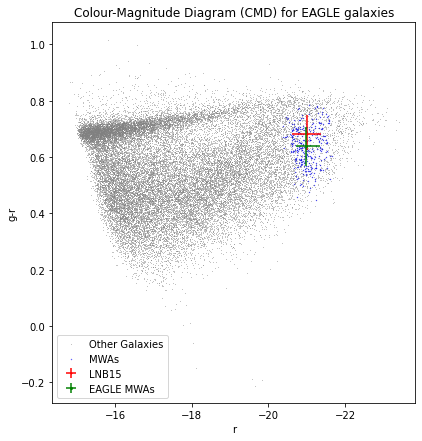

In [27]:
# Load the data
load_replaced_data = np.load('EAGLE_replaced_data.npy')

# Compute the color for all galaxies and MWAs
g_r_all = load_replaced_data['g_dust'] - load_replaced_data['r_dust']
stellarphotometrics_r_all = load_replaced_data['r_dust']

# Define the Milky Way analog (MWA) selection criteria
mw_stellar_mass = 6.08e10
mw_stellar_mass_err = 1.14e10
mw_sfr = 1.65
mw_sfr_err = 0.19

# Apply the box cut to select MWAs
mwa_indices = np.where(
    (load_replaced_data['stellar_mass'] >= mw_stellar_mass - 3 * mw_stellar_mass_err) &
    (load_replaced_data['stellar_mass'] <= mw_stellar_mass + 3 * mw_stellar_mass_err) &
    (load_replaced_data['SFR'] >= mw_sfr - 3 * mw_sfr_err) &
    (load_replaced_data['SFR'] <= mw_sfr + 3 * mw_sfr_err))

# Extract colors and magnitudes for MWAs
g_r_mwa = g_r_all[mwa_indices]
r_mwa = stellarphotometrics_r_all[mwa_indices]

# LNB15 values
lnb15_r = -21.00  # Absolute magnitude Mr
lnb15_g_r = 0.682  # Color (g-r)
lnb15_r_err = [0.37, 0.38]  # Error in r
lnb15_g_r_err = [0.056, 0.066]  # Error in (g-r)

# Now let's plot CMD
plt.figure(figsize=(6.5,7))
plt.scatter(stellarphotometrics_r_all, g_r_all, s=1, alpha=0.6, c='gray', linewidth=0, label='Other Galaxies')
plt.scatter(r_mwa, g_r_mwa, s=2, alpha=0.6, c='blue', linewidth=0, label='MWAs')

# Overplot the LNB15 values with error bars and 'x' marker style
lnb15_r_err_2d = np.array([[lnb15_r_err[0]], [lnb15_r_err[1]]])
lnb15_g_r_err_2d = np.array([[lnb15_g_r_err[0]], [lnb15_g_r_err[1]]])

plt.errorbar(lnb15_r, lnb15_g_r, xerr=lnb15_r_err_2d, yerr=lnb15_g_r_err_2d, fmt='+', c='red', markersize=2, label='LNB15')

 #Compute percentile values for r and g-r
r_center = np.percentile(r_mwa, 50)
r_lower = np.percentile(r_mwa, 16)
r_upper = np.percentile(r_mwa, 84)

g_r_center = np.percentile(g_r_mwa, 50)
g_r_lower = np.percentile(g_r_mwa, 16)
g_r_upper = np.percentile(g_r_mwa, 84)

# Compute errors from percentiles
r_err = [[r_center - r_lower], [r_upper - r_center]]
g_r_err = [[g_r_center - g_r_lower], [g_r_upper - g_r_center]]

#Overplot the percentile values with error bars
plt.errorbar(r_center, g_r_center, xerr=r_err, yerr=g_r_err, fmt='o', c='green', markersize=2, label='EAGLE MWAs')

plt.gca().invert_xaxis() 
plt.ylabel('g-r')  
plt.xlabel('r')
plt.title('Colour-Magnitude Diagram (CMD) for EAGLE galaxies')
plt.legend()
plt.show()


In [11]:
# Check the length of the arrays
g_r_all_length = len(g_r_all)
stellarphotometrics_r_all_length = len(stellarphotometrics_r_all)
g_r_mwa_length = len(g_r_mwa)
r_mwa_length = len(r_mwa)

# Print the lengths
print("Length of g_r_all:", g_r_all_length)
print("Length of stellarphotometrics_r_all:", stellarphotometrics_r_all_length)
print("Length of g_r_mwa:", g_r_mwa_length)
print("Length of r_mwa:", r_mwa_length)

Length of g_r_all: 40312
Length of stellarphotometrics_r_all: 40312
Length of g_r_mwa: 302
Length of r_mwa: 302


TNG

In [12]:
# 1. Importing TNG data
import os
import pickle

base = '/home/savelli/Illustris'

with open(os.path.join(base, 'data_all.npy'), 'rb') as f:
    data_all = pickle.load(f)

#print("Total sample size:", len(data_all['id']))
#print("Fields:", data_all.keys())


Number of Galaxies(TNG): 53939


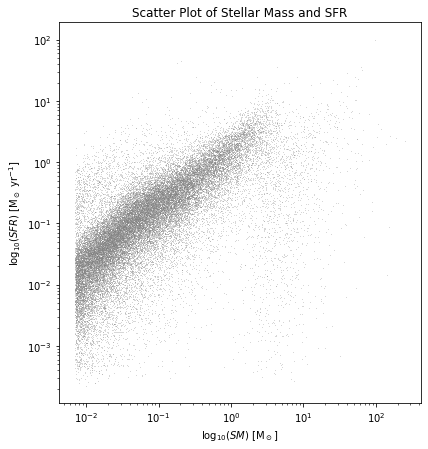

In [13]:
# 2. Make SFR vs SM plots for TNG
print("Number of Galaxies(TNG):", len(data_all['mass_stars']))
plt.figure(figsize=(6.5,7))
plt.scatter(data_all['mass_stars'], data_all['sfr'], s=1, alpha=0.4,c='gray',linewidth=0)
plt.xlabel(r'$\log_{10}(SM)\ [\mathrm{M}_\odot]$') # SM
plt.ylabel(r'$\log_{10}(SFR)\ [\mathrm{M}_\odot\ \mathrm{yr}^{-1}]$') #SFR
plt.yscale('log')
plt.xscale('log')
plt.title("Scatter Plot of Stellar Mass and SFR")
plt.show()

Number of MWAs(TNG): 264


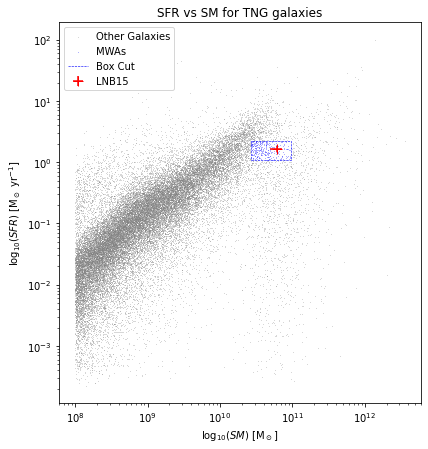

In [14]:
# 3. Make a box cut on the greater galaxy sample to pick out MWAs. 
import os
import pickle

base = '/home/savelli/Illustris'

with open(os.path.join(base, 'data_all.npy'), 'rb') as f:
    data_all = pickle.load(f)

# Given constants
mw_stellar_mass = 6.08e10
mw_stellar_mass_err = 1.14e10 
mw_sfr = 1.65
mw_sfr_err = 0.19 

for k in data_all.keys():
    if "mass" in k:
        data_all[k] = data_all[k] * 1e10 / 0.704

# Convert stellar masses from 1e10 M⊙ to M⊙
stellar_mass = np.array(data_all['mass_stars']) 
sfr = np.array(data_all['sfr'])

# Create a mask for MWAs
mwa_filter = ((stellar_mass > (mw_stellar_mass - 3 * mw_stellar_mass_err)) &
                (stellar_mass < (mw_stellar_mass + 3 * mw_stellar_mass_err)) &
                (sfr > (mw_sfr - 3 * mw_sfr_err)) &
                (sfr < (mw_sfr + 3 * mw_sfr_err)))

# Count MWAs
mwa_count = np.sum(mwa_filter)
print("Number of MWAs(TNG):", mwa_count)

#4. Overplot your MWAs on your SFR vs SM plot in a different colour.
plt.figure(figsize=(6.5,7))
plt.scatter(stellar_mass[~mwa_filter], sfr[~mwa_filter], s=1, alpha=0.4, linewidth=0, c='gray', label='Other Galaxies')
plt.scatter(stellar_mass[mwa_filter], sfr[mwa_filter], s=1, alpha=0.4, linewidth=0, c='blue', label='MWAs')

plt.errorbar(mw_stellar_mass, mw_sfr, xerr=mw_stellar_mass_err, yerr=mw_sfr_err, color='red', fmt='+', markersize=10, label='LNB15')
rectangle_x = [mw_stellar_mass - 3 * mw_stellar_mass_err, mw_stellar_mass + 3 * mw_stellar_mass_err, mw_stellar_mass + 3 * mw_stellar_mass_err, mw_stellar_mass - 3 * mw_stellar_mass_err, mw_stellar_mass - 3 * mw_stellar_mass_err]
rectangle_y = [mw_sfr - 3 * mw_sfr_err, mw_sfr - 3 * mw_sfr_err, mw_sfr + 3 * mw_sfr_err, mw_sfr + 3 * mw_sfr_err, mw_sfr - 3 * mw_sfr_err]
plt.plot(rectangle_x, rectangle_y, color='blue', linewidth=0.6, linestyle='--', label='Box Cut')

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\log_{10}(SM)\ [\mathrm{M}_\odot]$') # SM
plt.ylabel(r'$\log_{10}(SFR)\ [\mathrm{M}_\odot\ \mathrm{yr}^{-1}]$') #SFR
plt.title("SFR vs SM for TNG galaxies")
plt.legend()
plt.show()


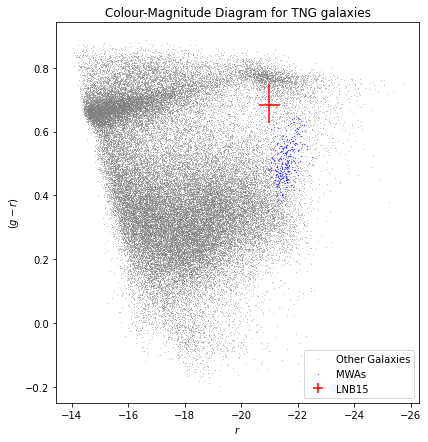

In [15]:
#5. Make a CMD (colour-magnitude diagram)
stellarphotometrics_g = np.array(data_all['stellarphotometrics_g'])
stellarphotometrics_r = np.array(data_all['stellarphotometrics_r'])

# Compute (g-r)
g_r = stellarphotometrics_g - stellarphotometrics_r

# LNB15 values
lnb15_r = -21.00  # Absolute magnitude Mr
lnb15_g_r = 0.682  # Color (g-r)
lnb15_r_err = [0.37, 0.38]  # Error in r
lnb15_g_r_err = [0.056, 0.066]  # Error in (g-r)


# Make a CMD for the other galaxies
plt.figure(figsize=(6.5,7))
plt.scatter(stellarphotometrics_r[~mwa_filter], g_r[~mwa_filter],  s=1, alpha=0.6, linewidth=0, c='gray', label='Other Galaxies')
# Overplot the MWAs in another colour
plt.scatter(stellarphotometrics_r[mwa_filter], g_r[mwa_filter], s=2, alpha=0.6, linewidth=0, c='blue', label='MWAs')

# Overplot the LNB15 values with error bars and 'x' marker style
lnb15_r_err_2d = np.array([[lnb15_r_err[0]], [lnb15_r_err[1]]])
lnb15_g_r_err_2d = np.array([[lnb15_g_r_err[0]], [lnb15_g_r_err[1]]])

plt.errorbar(lnb15_r, lnb15_g_r, xerr=lnb15_r_err_2d, yerr=lnb15_g_r_err_2d, fmt='+', c='red', markersize=2, label='LNB15')

plt.ylabel(r'$(g-r)$')  # Colour (g-r)
plt.xlabel(r'$r$')  # r magnitude
plt.title("Colour-Magnitude Diagram for TNG galaxies")
plt.gca().invert_xaxis()
plt.legend()
plt.show()



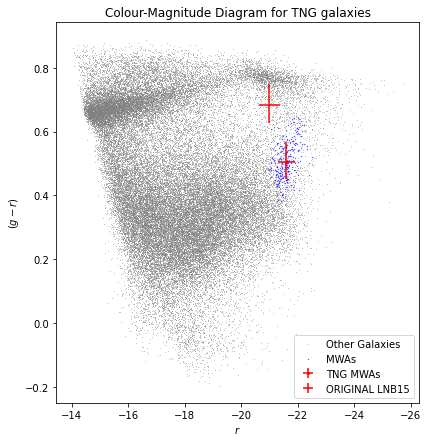

In [21]:
#5. Make a CMD (colour-magnitude diagram)
stellarphotometrics_g = np.array(data_all['stellarphotometrics_g'])
stellarphotometrics_r = np.array(data_all['stellarphotometrics_r'])

# Compute (g-r)
g_r = stellarphotometrics_g - stellarphotometrics_r

# LNB15 values
lnb15_r = -21.00  # Absolute magnitude Mr
lnb15_g_r = 0.682  # Color (g-r)
lnb15_r_err = [0.37, 0.38]  # Error in r
lnb15_g_r_err = [0.056, 0.066]  # Error in (g-r)


# Make a CMD for the other galaxies
plt.figure(figsize=(6.5,7))
plt.scatter(stellarphotometrics_r[~mwa_filter], g_r[~mwa_filter],  s=1, alpha=0.6, linewidth=0, c='gray', label='Other Galaxies')
# Overplot the MWAs in another colour
plt.scatter(stellarphotometrics_r[mwa_filter], g_r[mwa_filter], s=2, alpha=0.6, linewidth=0, c='blue', label='MWAs')

 #Compute percentile values for r and g-r
r_center = np.percentile(stellarphotometrics_r[mwa_filter], 50)
r_lower = np.percentile(stellarphotometrics_r[mwa_filter], 16)
r_upper = np.percentile(stellarphotometrics_r[mwa_filter], 84)

g_r_center = np.percentile(g_r[mwa_filter], 50)
g_r_lower = np.percentile(g_r[mwa_filter], 16)
g_r_upper = np.percentile(g_r[mwa_filter], 84)

# Compute errors from percentiles
r_err = [[r_center - r_lower], [r_upper - r_center]]
g_r_err = [[g_r_center - g_r_lower], [g_r_upper - g_r_center]]

#Overplot the percentile values with error bars
plt.errorbar(r_center, g_r_center, xerr=r_err, yerr=g_r_err, fmt='o', c='red', markersize=2, label='TNG MWAs')

# Overplot the LNB15 values with error bars and 'x' marker style
lnb15_r_err_2d = np.array([[lnb15_r_err[0]], [lnb15_r_err[1]]])
lnb15_g_r_err_2d = np.array([[lnb15_g_r_err[0]], [lnb15_g_r_err[1]]])

plt.errorbar(lnb15_r, lnb15_g_r, xerr=lnb15_r_err_2d, yerr=lnb15_g_r_err_2d, fmt='+', c='red', markersize=2, label='ORIGINAL LNB15')

plt.ylabel(r'$(g-r)$')  # Colour (g-r)
plt.xlabel(r'$r$')  # r magnitude
plt.title("Colour-Magnitude Diagram for TNG galaxies")
plt.gca().invert_xaxis()
plt.legend()
plt.show()
